In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# 1. The Basics
## 1.1 Cirq and parameterized quantum circuits
Before exploring TensorFlow Quantum (TFQ), let's look at some Cirq basics. Cirq is a Python library for quantum computing from Google. You use it to define circuits, including static and parameterized gates.

Cirq uses SymPy symbols to represent free parameters.

In [2]:
a, b = sympy.symbols('a b')

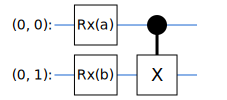

In [3]:
#Create a 2 qubit circuit using the parameters
q0, q1 = cirq.GridQubit.rect(1, 2)

circuit = cirq.Circuit(cirq.rx(a).on(q0), cirq.rx(b).on(q1), cirq.CNOT(control=q0, target=q1))

SVGCircuit(circuit)

To evaluate circuits, you can use the cirq.Simulator interface. You replace free parameters in a circuit with specific numbers by passing in a cirq.ParamResolver object. The following code calculates the raw state vector output of your parameterized circuit:

In [4]:
#Calculate a state vector with a = 0.5 and b = -0.5
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state

output_state_vector

array([0.9387913 +0.j        , 0.        +0.23971277j,
       0.06120872+0.j        , 0.        -0.23971277j], dtype=complex64)

State vectors are not directly accessible outside of simulation (notice the complex numbers in the output above). To be physically realistic, you must specify a measurement, which converts a state vector into a real number that classical computers can understand. Cirq specifies measurements using combinations of the Pauli operators , , and . As illustration, the following code measures  and  on the state vector you just simulated:

In [5]:
z0 = cirq.Z(q0)

qubit_map = {q0: 0, q1: 1}

z0.expectation_from_wavefunction(output_state_vector, qubit_map).real

0.8775825500488281

In [6]:
z0

cirq.Z(cirq.GridQubit(0, 0))

In [7]:
z0x1 = 0.5 * z0 + cirq.X(q1)
z0x1.expectation_from_wavefunction(output_state_vector, qubit_map).real

0.43879127502441406

## 1.2 Quantum circuits as tensors
TensorFlow Quantum (TFQ) provides tfq.convert_to_tensor, a function that converts Cirq objects into tensors. This allows you to send Cirq objects to our quantum layers and quantum ops. The function can be called on lists or arrays of Cirq Circuits and Cirq Paulis:

In [8]:
#Rank 1 Tensor containing 1 circuit 
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


This encodes the Cirq objects as tf.string tensors that tfq operations decode as needed.



In [9]:
#Rank 1 Tensor containing 2 Pauli operators
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])

pauli_tensor.shape

TensorShape([2])

# Batching circuit simulation
#### TFQ provides methods for computing expectation values, samples, and state vectors. For now, let's focus on expectation values.

The highest-level interface for calculating expectation values is the tfq.layers.Expectation layer, which is a tf.keras.Layer. In its simplest form, this layer is equivalent to simulating a parameterized circuit over many cirq.ParamResolvers; however, TFQ allows batching following TensorFlow semantics, and circuits are simulated using efficient C++ code.

Create a batch of values to substitute for our a and b parameters:

In [10]:
batch_vals = np.array(np.random.uniform(0, 2*np.pi, (5, 2)), dtype=np.float32)

In [11]:
#Batching Circuit Execution over parameters requires a loop
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state = cirq_simulator.simulate(circuit, resolver).final_state
    cirq_results.append(
        [z0.expectation_from_wavefunction(final_state, {
            q0: 0,
            q1: 1
        }).real])
    
    print(f'cirq batch results: \n{np.array(cirq_results)}')

cirq batch results: 
[[-0.6876595]]
cirq batch results: 
[[-0.6876595 ]
 [ 0.88599539]]
cirq batch results: 
[[-0.6876595 ]
 [ 0.88599539]
 [ 0.18062422]]
cirq batch results: 
[[-0.6876595 ]
 [ 0.88599539]
 [ 0.18062422]
 [-0.85753453]]
cirq batch results: 
[[-0.6876595 ]
 [ 0.88599539]
 [ 0.18062422]
 [-0.85753453]
 [ 0.99794132]]


In [12]:
#The Same operation is Simplified in TFQ
tfq.layers.Expectation()(circuit, symbol_names=[a, b], symbol_values=batch_vals, operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.68765956],
       [ 0.8859954 ],
       [ 0.18062422],
       [-0.8575345 ],
       [ 0.9979413 ]], dtype=float32)>

## 2. Hybrid quantum-classical optimization
Now that you've seen the basics, let's use TensorFlow Quantum to construct a hybrid quantum-classical neural net. You will train a classical neural net to control a single qubit. The control will be optimized to correctly prepare the qubit in the 0 or 1 state, overcoming a simulated systematic calibration error. This figure shows the architecture:

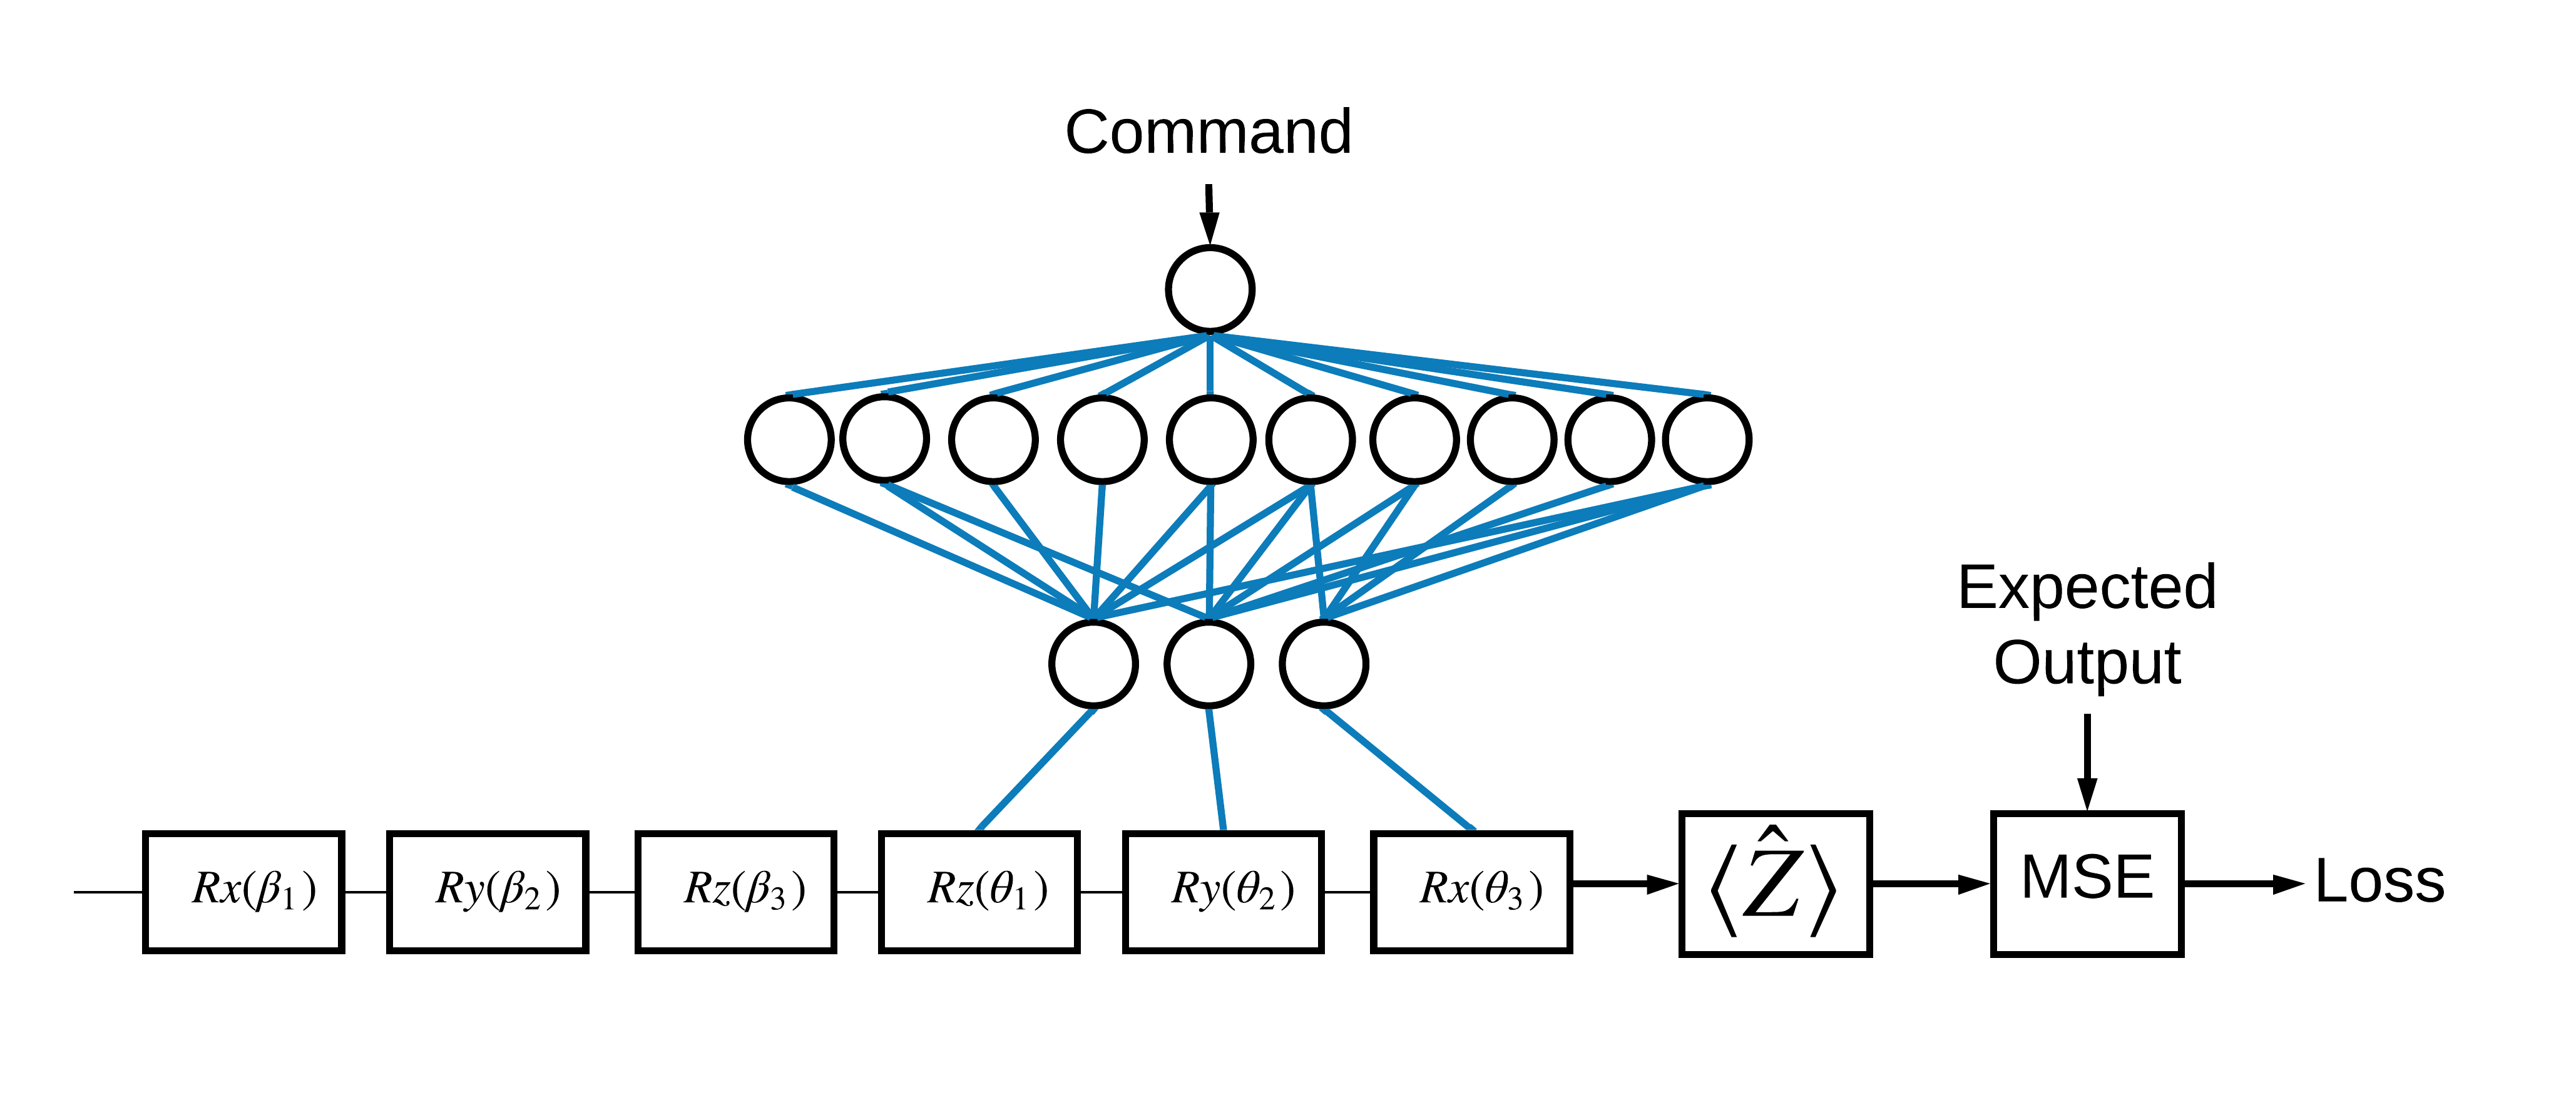

Even without a neural network this is a straightforward problem to solve, but the theme is similar to the real quantum control problems you might solve using TFQ. It demonstrates an end-to-end example of a quantum-classical computation using the tfq.layers.ControlledPQC (Parametrized Quantum Circuit) layer inside of a tf.keras.Model.

For the implementation of this tutorial, this is architecture is split into 3 parts:

The input circuit or datapoint circuit: The first three  gates.
The controlled circuit: The other three  gates.
The controller: The classical neural-network setting the parameters of the controlled circuit.

### The controlled circuit definition
Define a learnable single bit rotation, as indicated in the figure above. This will correspond to our controlled circuit.

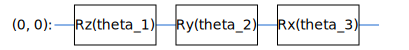

In [13]:
#Paramters that the Classical NN will feed values into
control_params = sympy.symbols('theta_1 theta_2 theta_3')

#Create the parameterized Circuit
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

### The controller
Now define controller network

In [14]:
#The Classical NN layer
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
])

Given a batch of commands, the controller outputs a batch of control signals for the controlled circuit.

The controller is randomly initialized so these outputs are not useful, yet.

In [15]:
controller(tf.constant([[0.0], [1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.3085779 ,  0.2164681 , -0.01750613]], dtype=float32)

## Connect the controller to the circuit
Use tfq to connect the controller to the controlled circuit, as a single keras.Model.

See the Keras Functional API guide for more about this style of model definition.

First define the inputs to the model:

In [16]:
#This input is the simulated miscalibration that the model will learn to connect
circuits_input = tf.keras.Input(shape=(), dtype=tf.string, name='circuits_input') #circuit-tensor has tf.string as dtype


#Commands will be either `0` or `1` specifying the state to set the qubit to
commands_input = tf.keras.Input(shape=(1, ), dtype=tf.dtypes.float32, name='commands_input')

Next Apply operations to those inputs to define the computation

In [17]:
dense_2 = controller(commands_input)

#TFQ layer for classically controlled circuits
expectation_layer = tfq.layers.ControlledPQC(model_circuit, operators=cirq.Z(qubit))#observe Z

expectation = expectation_layer([circuits_input, dense_2])

#### Now Package the Computation as tf.keras.Model

In [18]:
#The full Keras Model is built from our layers
model = tf.keras.Model(inputs=[circuits_input, commands_input], outputs=expectation)

#####  The network architecture is indicated by the plot of the model below. Compare this model plot to the architecture diagram to verify correctness.

 

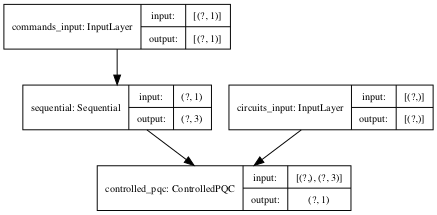

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

##### This model takes two inputs: The commands for the controller, and the input-circuit whose output the controller is attempting to correct.

# The dataset
The model attempts to output the correct correct measurement value of  for each command. The commands and correct values are defined below.

In [21]:
#The Command input values to the classical NN
commands = np.array([[0], [1]], dtype=np.float32)

#The desired Z expectation value at output of the quantum circuit
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

This is not the entire training dataset for this task. Each datapoint in the dataset also needs an output circuit.

# Input circuit definition
The input-circuit below defines the random miscalibration the model will learn to correct.

In [23]:
random_rotations = np.random.uniform(0, 2*np.pi, 3)
noisy_preparation = cirq.Circuit(
    cirq.rx(random_rotations[0])(qubit),
    cirq.ry(random_rotations[1])(qubit),
    cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
    noisy_preparation
] * 2) #Make 2 copies of this circuit

In [24]:
datapoint_circuits.shape

TensorShape([2])

## Training

In [25]:
model([datapoint_circuits, commands]).numpy()

array([[0.14363801],
       [0.1659975 ]], dtype=float32)

##### Now run a standard training process to adjust these values towards the expected_outputs. 

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer, loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30, verbose=0)

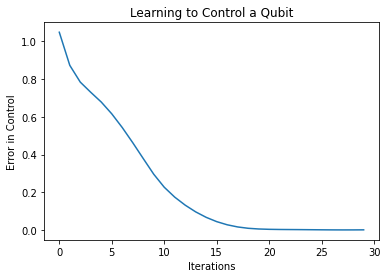

In [27]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

From this plot you can see that the neural network has learned to overcome the systematic miscalibration.

# Verify outputs
Now use the trained model, to correct the qubit calibration errors. With Cirq:

In [28]:
def check_error(command_values, desired_values):
    """
    Based on the value in `command_value` see how well you could prepare the full circuit to have `desired_value`
    when taking expectation w.r.t Z.
    """
    params_to_prepare_output = controller(command_values).numpy()
    full_circuit = noisy_preparation + model_circuit
    
    #Test how well you can prepare a state to get expectation the expectation
    #value in `desired_values`
    for index in [0, 1]:
        state = cirq_simulator.simulate(
            full_circuit,
            {s:v for (s, v) in zip(control_params, params_to_prepare_output[index])}
        ).final_state
        expectation = z0.expectation_from_wavefunction(state, {qubit: 0}).real
        print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expectation}\n')
    
check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [-1.0384115  -1.1862885   0.76769024]
Which gives an actual expectation of: 0.9238839149475098

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [ 0.23669183 -1.2883778  -1.5690017 ]
Which gives an actual expectation of: -0.9813729524612427



###### The value of the loss function during training provides a rough idea of how well the model is learning. The lower the loss, the closer the expectation values in the above cell is to desired_values. If you aren't as concerned with the parameter values, you can always check the outputs from above using tfq:

In [29]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.92388374],
       [-0.9813731 ]], dtype=float32)>

### Learning to prepare eigenstates of different operators
The choice of the  eigenstates corresponding to 1 and 0 was arbitrary. You could have just as easily wanted 1 to correspond to the  eigenstate and 0 to correspond to the  eigenstate. One way to accomplish this is by specifying a different measurement operator for each command, as indicated in the figure below: 

# 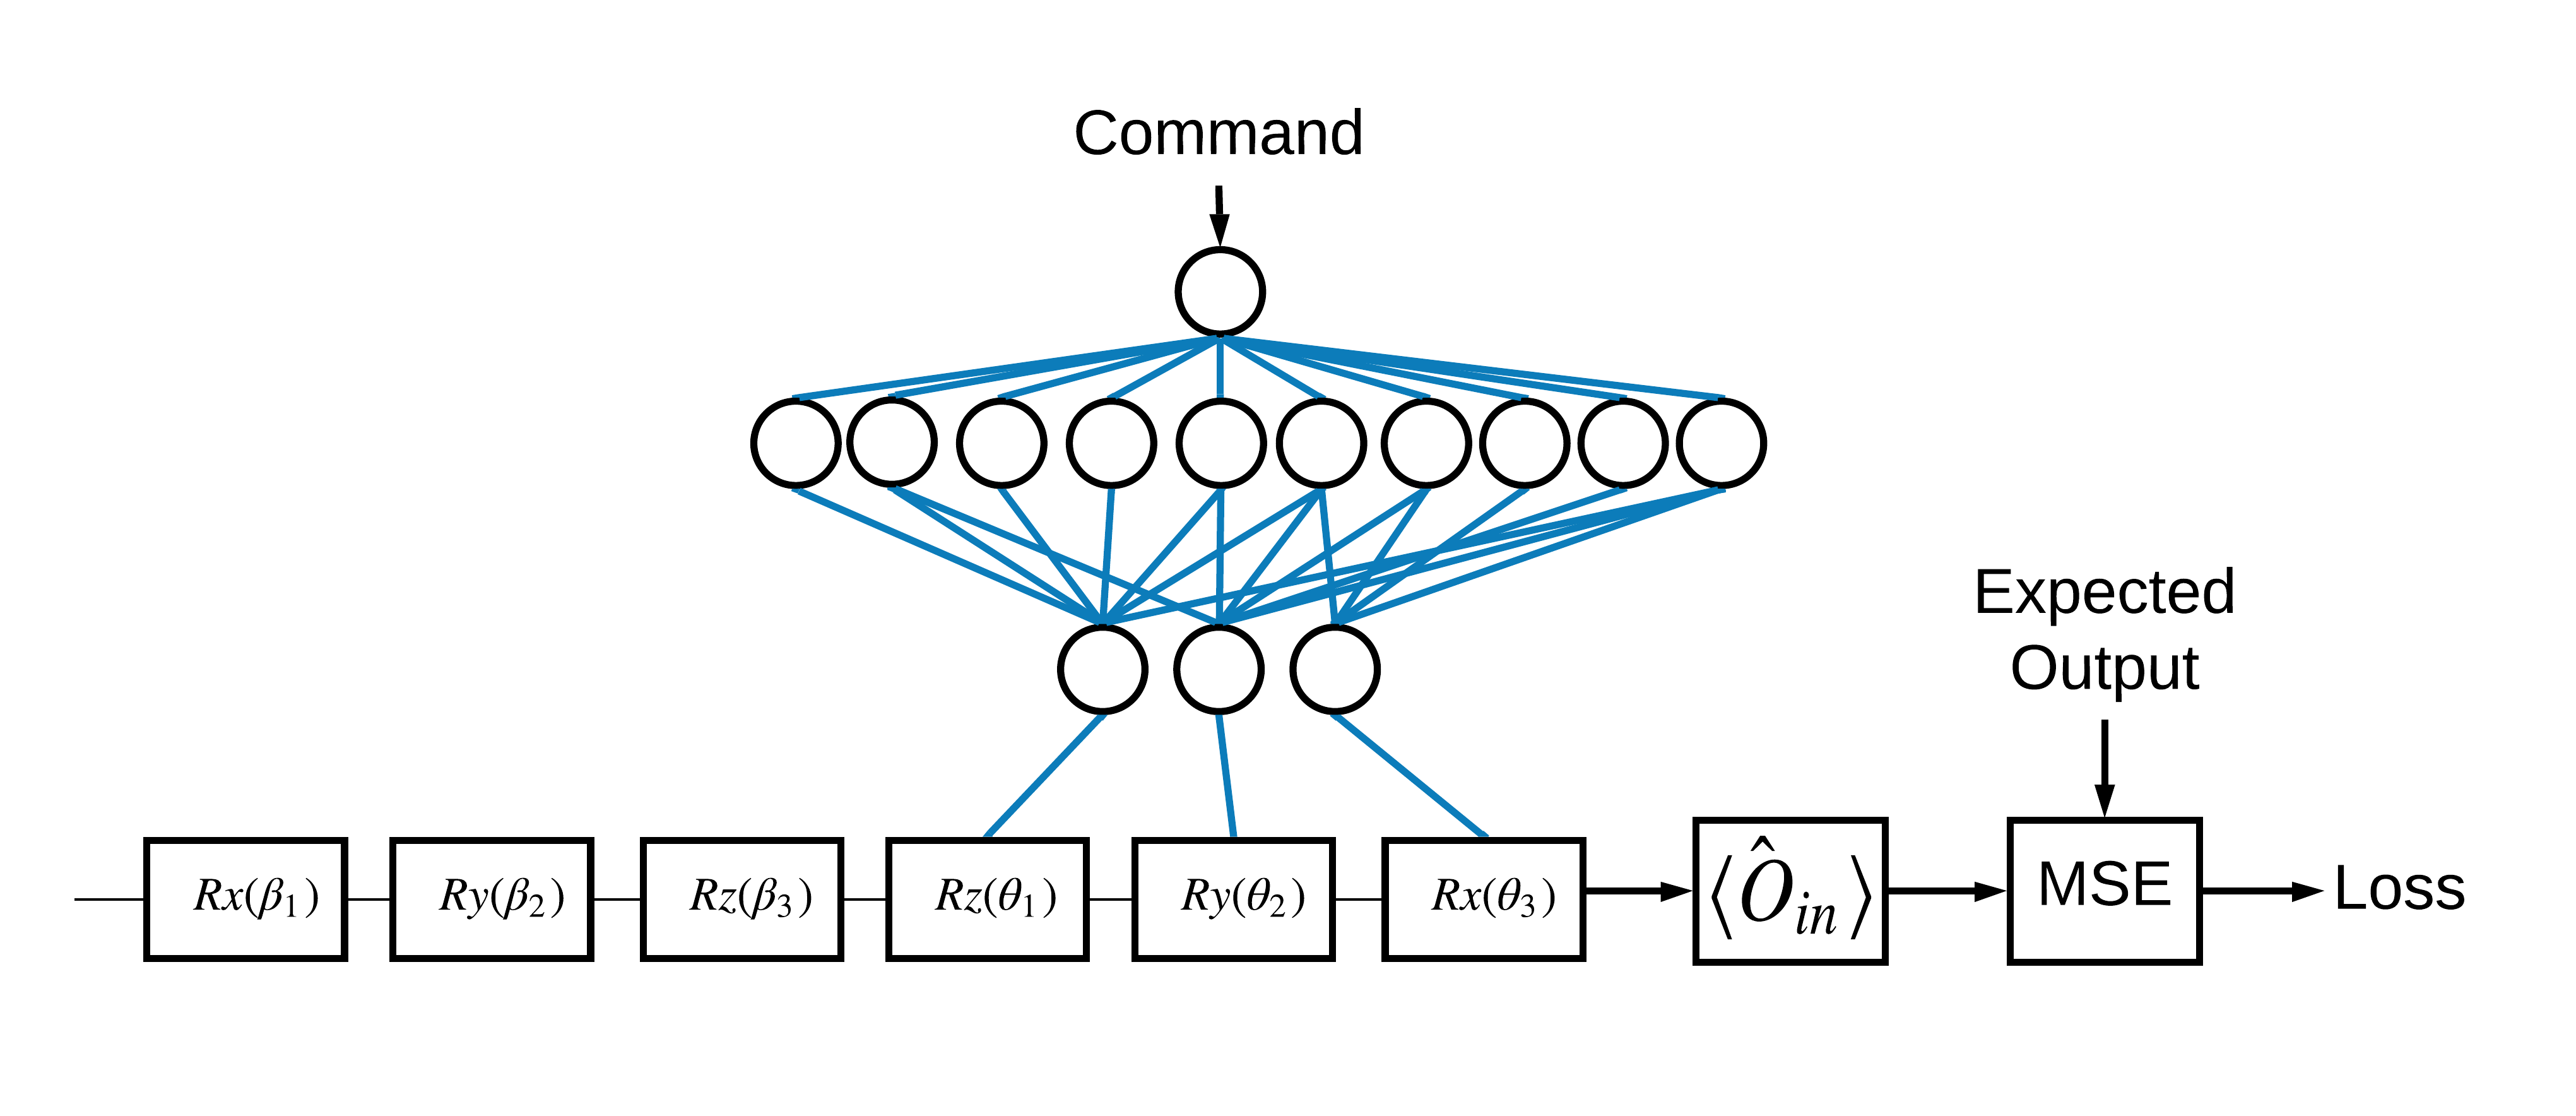

This requires use of tfq.layers.Expectation. Now your input has grown to include three objects: circuit, command, and operator. The output is still the expectation value.

In [30]:
#New Model Definition
#DEFINE THE INPUTS
commands_input = tf.keras.layers.Input(shape=(1), dtype=tf.dtypes.float32, name='commands_input')

circuits_input = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string, name='circuits_input')

operators_input = tf.keras.layers.Input(shape=(1,), dtype=tf.dtypes.string, name='operators_input')

In [31]:
#The Controller Neural Network
#DEFINE THE CLASSICAL NN
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

Combine the Circuit and Controller into a single keras.Model using tfq  

In [32]:
dense_2 = controller(commands_input)

#Since we are not using a PQC or ControlledPQC we must append the model circuit onto the datapoint circuit tensor manually
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)

#Construct the Keras Model
two_axis_control_model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

# The dataset
Now you will also include the operators you wish to measure for each datapoint you supply for model_circuit:

In [33]:
#The operators to measure, for each command
operator_data = tfq.convert_to_tensor([[cirq.X(qubit)], [cirq.Z(qubit)]])

#The Command input values to the classical NN
commands = np.array([[0], [1]], dtype=np.float32)

#The desired expectation value at output of quantum circuit
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

# Training
Now that you have your new inputs and outputs you can train once again using keras.



In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()

two_axis_control_model.compile(optimizer=optimizer, loss=loss)

history = two_axis_control_model.fit(
    x = [datapoint_circuits, commands, operator_data],
    y = expected_outputs, epochs=30, verbose=1)

Train on 2 samples
Epoch 1/30
2/2 [==============================] - 1s 446ms/sample - loss: 1.2427
Epoch 2/30
2/2 [==============================] - 0s 3ms/sample - loss: 0.5121
Epoch 3/30
2/2 [==============================] - 0s 7ms/sample - loss: 0.2639
Epoch 4/30
2/2 [==============================] - 0s 4ms/sample - loss: 0.1630
Epoch 5/30
2/2 [==============================] - 0s 5ms/sample - loss: 0.0996
Epoch 6/30
2/2 [==============================] - 0s 5ms/sample - loss: 0.0802
Epoch 7/30
2/2 [==============================] - 0s 4ms/sample - loss: 0.0709
Epoch 8/30
2/2 [==============================] - 0s 5ms/sample - loss: 0.0415
Epoch 9/30
2/2 [==============================] - 0s 6ms/sample - loss: 0.0143
Epoch 10/30
2/2 [==============================] - 0s 3ms/sample - loss: 0.0034
Epoch 11/30
2/2 [==============================] - 0s 4ms/sample - loss: 0.0018
Epoch 12/30
2/2 [==============================] - 0s 5ms/sample - loss: 0.0028
Epoch 13/30
2/2 [===========

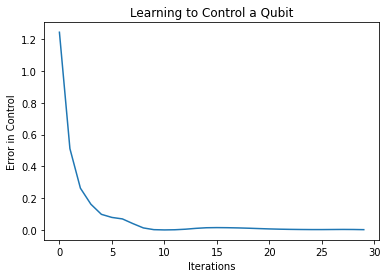

In [35]:
plt.plot(history.history['loss'])
plt.title('Learning to Control a Qubit')
plt.xlabel('Iterations')
plt.ylabel('Error in Control')
plt.show()

The loss function has dropped to zero.

The controller is available as a stand-alone model. Call the controller, and check its response to each command signal. It would take some work to correctly compare these outputs to the contents of random_rotations.

In [36]:
controller.predict(np.array([0, 1]))

array([[-1.525398  ,  0.47843525, -1.1002359 ],
       [-1.8096089 , -1.3354155 , -3.7434812 ]], dtype=float32)